In [1]:
%%bash 
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
pip install pyspark &> /dev/null

In [2]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import pandas as pd

# seting master("local[*]") enables multicore processing on all available logical cores on your machine
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [30]:
#data cleaning

raw_review = spark.read.option("Header", True).csv("raw_yelp_review_data.csv")


In [31]:
raw_review = raw_review.withColumnRenamed('full_review_text', 'text')


In [32]:
# Calculate the fraction required to get approximately 1000 rows
total_rows = raw_review.count()
num_rows_to_pick = 100
fraction = num_rows_to_pick / total_rows

# Randomly sample the required number of rows without replacement
raw_review = raw_review.sample(False, fraction)

In [33]:
raw_review = raw_review.na.drop(subset=['text'])

In [34]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StandardScaler, PCA
tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = feature.CountVectorizer(inputCol='filtered', outputCol='tf')
idf = feature.IDF(inputCol='tf', outputCol='tfidf')
center = StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')
pca = PCA(k=2, inputCol='centered_tfidf', outputCol='scores')


tfidf = Pipeline(stages=[tokenizer, sw_filter, cv, idf]).fit(raw_review)
tfidf.transform(raw_review).toPandas().head()

,coffee_shop_name,text,star_rating,words,filtered,tf,tfidf
0,The Factory - Cafe With a Soul,11/30/2016 Love this place. I really apprecia...,5.0 star rating,"[love, this, place, really, appreciate, the, l...","[love, place, really, appreciate, lack, wifi, ...","(0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.6523251860396901, 0.0, 0.0, 3.69643104..."
1,The Marvelous Vintage Tea Party Co.,11/19/2012 Sophie at Marvelous Vintage Tea Pa...,5.0 star rating,"[sophie, at, marvelous, vintage, tea, party, c...","[sophie, marvelous, vintage, tea, party, compa...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.2685113254635072, ..."
2,Vintage Heart Coffee,11/19/2015 2 check-ins Listed in Life is like...,4.0 star rating,"[check, ins, listed, in, life, is, like, cup, ...","[check, ins, listed, life, like, cup, coffee, ...","(4.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.3209667474823072, 1.3046503720793803, 0.0, ..."
3,Vintage Heart Coffee,5/24/2016 1 check-in Really sweet coffee shop...,4.0 star rating,"[check, in, really, sweet, coffee, shop, on, t...","[check, really, sweet, coffee, shop, east, exp...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.3302416868705768, 0.0, 0.0, 0.8266785731844..."
4,Mozart’s Coffee Roasters,11/6/2016 Amazing view. But very bland cappuc...,2.0 star rating,"[amazing, view, but, very, bland, cappuccino, ...","[amazing, view, bland, cappuccino, feel, like,...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.2685113254635072, ..."


In [35]:
s = Pipeline(stages=[tokenizer, sw_filter, cv, idf,center,pca]).fit(raw_review)

In [39]:
s.transform(raw_review).toPandas().head()

,coffee_shop_name,text,star_rating,words,filtered,tf,tfidf,centered_tfidf,scores
0,The Factory - Cafe With a Soul,11/30/2016 Love this place. I really apprecia...,5.0 star rating,"[love, this, place, really, appreciate, the, l...","[love, place, really, appreciate, lack, wifi, ...","(0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.6523251860396901, 0.0, 0.0, 3.69643104...","[-0.5040531010129856, 0.1304650372079379, -0.4...","[0.2081983612332375, 0.9231239893966533]"
1,The Marvelous Vintage Tea Party Co.,11/19/2012 Sophie at Marvelous Vintage Tea Pa...,5.0 star rating,"[sophie, at, marvelous, vintage, tea, party, c...","[sophie, marvelous, vintage, tea, party, compa...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.2685113254635072, ...","[-0.5040531010129856, -0.5218601488317522, -0....","[1.4560546120440943, 0.47612531148396653]"
2,Vintage Heart Coffee,11/19/2015 2 check-ins Listed in Life is like...,4.0 star rating,"[check, ins, listed, in, life, is, like, cup, ...","[check, ins, listed, life, like, cup, coffee, ...","(4.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.3209667474823072, 1.3046503720793803, 0.0, ...","[0.8169136464693216, 0.782790223247628, -0.495...","[0.7375963343248015, -2.325947719046695]"
3,Vintage Heart Coffee,5/24/2016 1 check-in Really sweet coffee shop...,4.0 star rating,"[check, in, really, sweet, coffee, shop, on, t...","[check, really, sweet, coffee, shop, east, exp...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.3302416868705768, 0.0, 0.0, 0.8266785731844...","[-0.1738114141424088, -0.5218601488317522, -0....","[-0.16097970560409075, 0.4428450533539456]"
4,Mozart’s Coffee Roasters,11/6/2016 Amazing view. But very bland cappuc...,2.0 star rating,"[amazing, view, but, very, bland, cappuccino, ...","[amazing, view, bland, cappuccino, feel, like,...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.2685113254635072, ...","[-0.5040531010129856, -0.5218601488317522, -0....","[0.7393906833449052, 0.5669621128521193]"


In [40]:
pca_model = s.stages [-1]
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()


vocabulary = s.stages[2].vocabulary

pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2',})
print(pc_loadings.shape)

(1684, 3)


In [41]:
pd.concat((pc_loadings.sort_values('load_pc1').head(), 
           pc_loadings.sort_values('load_pc1').tail()))

,word,load_pc1,load_pc2
279,fried,-0.24871,0.010764
293,boba,-0.24871,0.010764
203,toast,-0.223641,0.010806
25,tea,-0.216251,0.027715
10,really,-0.212195,0.045214
30,times,0.01035,-0.038565
338,omelette,0.0104,-0.008223
350,cheese,0.0104,-0.008223
197,grove,0.010406,0.008174
117,event,0.016934,0.014483


In [42]:
pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail()))

,word,load_pc1,load_pc2
71,espresso,-0.001031,-0.207604
396,addition,-0.007944,-0.184054
647,culture,-0.007944,-0.184054
245,shot,-0.005288,-0.167831
261,congress,-0.006473,-0.167662
64,hours,-0.005802,0.029703
132,game,0.009777,0.033271
10,really,-0.212195,0.045214
66,location,-0.028814,0.047331
76,flavors,-0.049418,0.059492


In [43]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, 
                                   feature.Normalizer(inputCol='tfidf', outputCol='norm_tfidf'), 
                                   feature.StandardScaler(withMean=True, withStd=False, 
                                                          inputCol='norm_tfidf',
                                                          outputCol='centered_tfidf'),
                                   feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')])\
    .fit(raw_review)

In [44]:
cname = np.array(raw_review.select('coffee_shop_name').rdd.map(lambda x: x['coffee_shop_name']).collect())
X = np.array(pipeline2_model.transform(raw_review).select('scores').rdd.map(lambda x: x['scores']).collect())
print("X.shape:", X.shape)

X.shape: (95, 2)


In [45]:
print("Length of cname:", len(cname))
print("Length of X:", len(X))

Length of cname: 95
Length of X: 95


IndexError: ignored

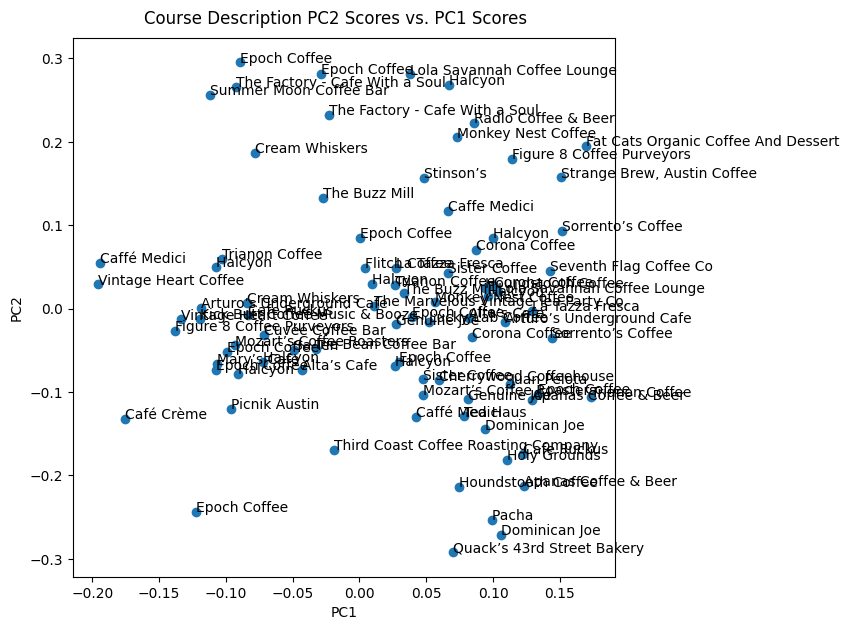

In [57]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(X[:,0], X[:,1])
fig.suptitle("Course Description PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i, txt in enumerate(cname):
    ax.annotate(txt, (X[i,0], X[i,1]))
    
display(plt.show())

In [58]:
pca_model = pipeline2_model.stages[-1]

In [61]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()
vocabulary = pipeline2_model.stages[2].vocabulary
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                     1: 'load_pc1',
                                                                     2: 'load_pc2'})

In [62]:
pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).head(5)

,word,load_pc1
177,patio,0.176898
13,friendly,0.165182
53,perfect,0.161334
113,sit,0.155119
45,super,0.138382


In [63]:
pc_loadings.sort_values('load_pc2').\
    apply({'word': lambda x: x, 'load_pc2': np.abs}, axis=0).head(5)

,word,load_pc2
61,review,0.161259
36,sandwich,0.140088
98,egg,0.124497
175,updated,0.118953
40,ordered,0.107398


In [70]:
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)
kmeans = clustering.KMeans(k=5, featuresCol='norm_tfidf', predictionCol='kmeans_feat')
p = Pipeline(stages=[tokenizer, sw_filter, cv, idf, center,norm, kmeans, pca])
pipeline_model1= p.fit(raw_review)

In [71]:
pd.set_option('display.max_colwidth', -1)
display("coffee shop:", raw_review.toPandas().head())
display("shops grouped by k-means group:", pipeline_model1.transform(raw_review).\
        groupBy('kmeans_feat').agg(fn.collect_list(
        fn.concat_ws('-', fn.col('coffee_shop_name'))).alias('desc')).toPandas().head())

<ipython-input-71-3382e094abe3>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


'coffee shop:'

,coffee_shop_name,text,star_rating
0,The Factory - Cafe With a Soul,"11/30/2016 Love this place. I really appreciate the lack of wifi. Makes it much easier to have good conversations or lose yourself in a good book. Agree that it's a bit pricey, but the drinks are really good.",5.0 star rating
1,The Marvelous Vintage Tea Party Co.,"11/19/2012 Sophie at Marvelous Vintage Tea Party Company was absolutely amazing to work with. She puts in a huge amount of time and effort into planning exactly what you want at a budget you are comfortable with. What I especially liked about this was the fact that she's willing to let customers handle certain aspects of the event if they'd like to make their budget smaller. For example, she suggested we purchase our own flowers at wholesale. She also has connections with a liquor merchant in Austin that allows you 15% off your alcohol purchases for the event--a fantastic deal! In terms of venue, a MVTPC celebration can be hosted anywhere in the Austin areas--Sophie was more than willing to drive to Round Rock to make our celebration happen. Finally, Sophie's attention to detail and vast selection of vintage decor and delicious menu selections are sure to make your celebration a HUGE success!",5.0 star rating
2,Vintage Heart Coffee,"11/19/2015 2 check-ins Listed in Life is like a cup of coffee This place is quiet! I mean shhh quiet making it the perfect place to get some work done. The background music is barely noticeable, there are ample electrical plugs throughout the coffee shop and it is comfortable. I had 30 minutes to spare on the east side nearby Vintage Coffee and decided to cozy up with a cold brew and a Topo Chico. Service was friendly and I was happy with their selection of caffeine and variety of mineral waters. I haven't been drinking coffee for about 15 months so I was timid about going for the cold brew. The barista on duty shared that it is pretty mild and it is as blend a couple different coffees. I also opted for a Topo Chico. The cold brew was on the mild side and was served up in a mason jar. I found a comfortable couch and enjoyed my caffeinated beverage. Tips: The wifi password is ilovepuppies, now how cute is that! There are food trailers next door if you are hungry and want a change of scenery. Topo and cold brew",4.0 star rating
3,Vintage Heart Coffee,5/24/2016 1 check-in Really sweet coffee shop on the east side. I expected something super hipster but it was actually just calm and simple. They make a solid cappuccino and there are tables outside so you can sit and observe a typical East 7th morning. Bonus points for going green with cloth napkins!,4.0 star rating
4,Mozart’s Coffee Roasters,11/6/2016 Amazing view. But very bland cappuccino. I feel like chugging a glass of warm milk. My first time here so not too sure if its a one time mistake or not.,2.0 star rating


'shops grouped by k-means group:'

,kmeans_feat,desc
0,1,"[The Factory - Cafe With a Soul , The Marvelous Vintage Tea Party Co. , Vintage Heart Coffee , Mozart’s Coffee Roasters , Mozart’s Coffee Roasters , Monkey Nest Coffee , Apanas Coffee & Beer , Corona Coffee , Corona Coffee , Corona Coffee , Café Crème , Epoch Coffee , Epoch Coffee , Houndstooth Coffee , Caffe Medici , Holy Grounds , Figure 8 Coffee Purveyors , Fat Cats Organic Coffee And Dessert , Epoch Coffee , Epoch Coffee , Epoch Coffee , Epoch Coffee , Epoch Coffee , Mary’s Cafe , Caffé Medici , Caffé Medici , Third Coast Coffee Roasting Company , Apanas Coffee & Beer , Halcyon , Cherrywood Coffeehouse , Arturo’s Underground Cafe , Arturo’s Underground Cafe , Lucky Lab Coffee , Cream Whiskers , Cream Whiskers , Lola Savannah Coffee Lounge , Seventh Flag Coffee Co , Halcyon , Halcyon , Halcyon , Irie Bean Coffee Bar , Sa-Ten , Tea Haus , Sorrento’s Coffee , Sorrento’s Coffee , Cafe Ruckus , Cafe Ruckus , The Buzz Mill , The Buzz Mill , Halcyon , Halcyon , Genuine Joe , Radio Coffee & Beer , Trianon Coffee , Trianon Coffee , Picnik Austin , Kick Butt Coffee Music & Booze , La Tazza Fresca , La Tazza Fresca , Epoch Coffee , Epoch Coffee , Sister Coffee , Sister Coffee , Pacha , Strange Brew, Austin Coffee , Quack’s 43rd Street Bakery , Alta’s Cafe , Alta’s Cafe , Teo , Teo , My Sweet Austin , Café Java , Live Oak Market , Hot Mama’s Cafe , Hot Mama’s Cafe , The Steeping Room ]"
1,6,[Monkey Nest Coffee ]
2,3,"[Vintage Heart Coffee , The Factory - Cafe With a Soul , Flitch Coffee , Figure 8 Coffee Purveyors ]"
3,5,"[Cuvée Coffee Bar , Emerald Tavern Games & Cafe ]"
4,4,"[Halcyon , Halcyon , Trianon Coffee , Juan Pelota ]"


In [72]:
from pyspark.sql import types

In [73]:
import numpy as np
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

In [74]:
l2_dist_udf = fn.udf(l2_dist, types.FloatType())